# Reduced Dataset from UCI 

## Loading data and calculating indices 

In [214]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # for the progress bar :) 

# for single csv file of 1,000 instants, use this directory & change file name as needed
#Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/12_Files_1000_instant_each/"
#File_name = "1.csv" # files 1 - 12, each with 1,000 instants

# To load all data from a single file: 
Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/Single_File/"
File_name = "All_Signals.csv" # All instants, 12,000, in a single csv file

# Now read data header-less then give the col names
Signals = pd.read_csv(Data_Dir + File_name, header=None) #.reset_index()
Signals.columns = ['PPG','ABP','ECG'] # adding columns' names

# Reading the instants' lengthes to be used for calculating indices
Data_Indices = pd.read_csv(Data_Dir+"Instants_Length.csv", header=None)
Data_Indices.columns = ['Num_Samples']

# Calculating Instant Indices, Start & End
End_indices = np.cumsum(Data_Indices["Num_Samples"])
Start_indices = np.append(0, End_indices) 

# Sampling frequency
Fs=125


[ 28  86 143 202 260 318 376 432 491]


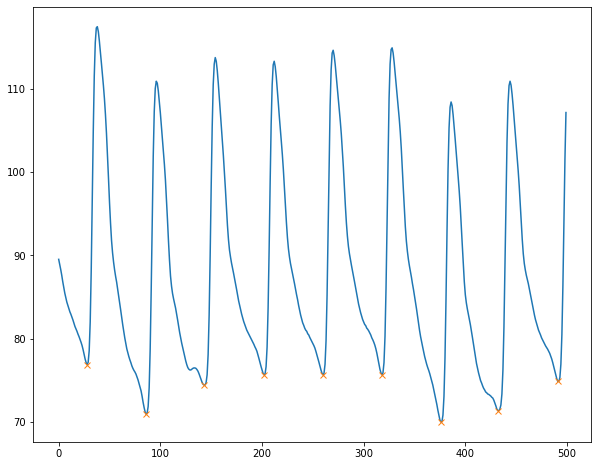

In [158]:
xyz = Signals['ABP'].iloc[Start_indices[17]:End_indices[17]+1]
from scipy.signal import find_peaks
ploc2 , _ = find_peaks(-1*xyz[0:500], distance=30)
print((ploc2))
plt.plot(np.arange(0,500),xyz[0:500])
plt.plot(ploc2, xyz.iloc[ploc2], "x");

## Converting signals into PTT, HR, SBP, DBP values

In [215]:
# Looping over the instants, processing them one by one, storing processed data (PTT, SBP, DBP) in another dataframe
All_Instants_Data = pd.DataFrame() 

# Which instants would you like to explore?
iStart, iEnd = 1, 12000 # 1:12,000
Instants_ID = np.arange(iStart - 1, iEnd)
Subset_Size = 5*125 # take 5 seconds at a time

for ID in tqdm(Instants_ID):  
    Instant_DF = Process_Instant(Signals.iloc[Start_indices[ID]:End_indices[ID]+1], Subset_Size)  # Processing data for 1 instant
    All_Instants_Data = All_Instants_Data.append(Instant_DF, ignore_index=True) # Appending to the whole processed dataset

  9%|███████▏                                                                     | 1119/12000 [01:58<15:29, 11.71it/s]C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [19:43<00:00, 10.14it/s]


In [216]:
All_Instants_Data.describe()

,PTT,SBP,DBP,HR
count,528623.000000,528825.000000,528825.000000,528820.000000
mean,-0.348844,116.456967,71.101752,28.016625
std,1.056021,21.472396,12.445288,6.553874
min,-4.828314,58.612937,50.000000,15.397523
25%,-0.650745,100.355083,62.022857,22.818071
50%,0.100549,113.826882,68.786545,27.105020
75%,0.338613,130.536176,77.823562,32.619429
max,0.915757,199.366000,188.367500,97.604000


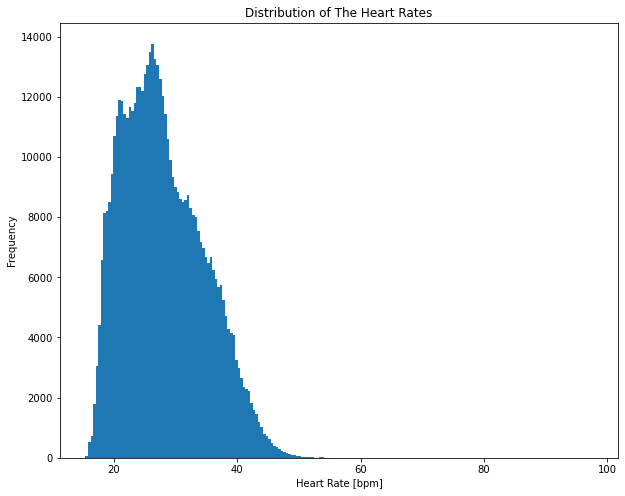

In [224]:
#All_Instants_Data.to_csv('Extracted_Instants_Parameters.csv')
plt.rcParams["figure.figsize"]=10,8
Data_intervals_minutes = All_Instants_Data['HR']
Data_intervals_minutes.plot(kind='hist', bins=200)
plt.xlabel("Heart Rate [bpm]");
plt.title("Distribution of The Heart Rates");

## Helper Functions

### PPG, ABP, ECG signals to PTT, SBP, DBP values

In [185]:
def Process_Instant(Signals, Subset_Size = 125*3): # defulat Subset_Size to cover 3 seconds of data samples
    
    import numpy as np
    from scipy.signal import find_peaks
    import pandas as pd
    
    N_tot = len(Signals.index) # Total number of samples
    N_ps = Subset_Size # Num of points per subset
    N_ss = N_tot//N_ps # Number of subsets (each with N_ps points), discarding the last points < N_ps
    All_data=pd.DataFrame() # an empty DF to store the parameters we got from the processed data 
    fs=125 # used to convert PPTp from Number_of_samples to time (same as in main. If changed, pass it to this fn)
    
    for i in range(N_ss):  # USE find_peaks_cwt instead??
           
        # ECG peaks' locations
        ECG_peaks, _ = find_peaks(Signals['ECG'][i*N_ps:(i+1)*N_ps], distance=30) 
        if len(ECG_peaks)<2: 
            print('ECG')
            continue
        
        # PPG peaks' locations
        PPG_peaks, _ = find_peaks(Signals['PPG'][i*N_ps:(i+1)*N_ps], distance=30)
        if len(PPG_peaks)<2: 
            print('PPG')
            continue
        
        if PPG_peaks[-1]<ECG_peaks[0]: 
            print('ECG lagging too much')
            continue
        
        # PPT Calculations:
        # The 1st PPG peak has to lag the 1st ECG peak, if not then drop it and consider the next one.
        Lp, Le = len(PPG_peaks), len(ECG_peaks)
        min_pe = min(Lp, Le)
        
        
        if PPG_peaks[0]>ECG_peaks[0]: # may add more conditions here for ACCEPTABLE PTT values
            PTT_vec = PPG_peaks[:min_pe] - ECG_peaks[:min_pe]
        else: # start from the 2nd PPG peak all the way to one before the last ECG peak
            s = 1
            while (PPG_peaks[s]<ECG_peaks[0]) and (s<=Lp-1):
                s+=1
            PTT_vec = PPG_peaks[s:min_pe] - ECG_peaks[:min_pe-s] 
        
        PTT_vec_p = [x for x in PTT_vec if x>0]
                
        PTT_avg = np.mean(PTT_vec_p)
        
        
        
        # BP Min & Max Peaks' (DBP & SBP) locations
        BPmax_peaks, _ = find_peaks(Signals['ABP'][i*N_ps:(i+1)*N_ps], distance=30) # indices of SBP
        BPmin_peaks, _ = find_peaks(-1*Signals['ABP'][i*N_ps:(i+1)*N_ps], distance=30) # indices of DBP
        
        
            # Calculate HR by averaging distances from ECG, PPG, BPmax, BPmin
        HR_ECG = np.mean(np.diff(ECG_peaks))
        HR_PPG = np.mean(np.diff(PPG_peaks))
        HR_SBP = np.mean(np.diff(BPmax_peaks))
        HR_DBP = np.mean(np.diff(BPmin_peaks))
        HR_avg = 60*(HR_ECG + HR_PPG + HR_SBP + HR_DBP)/(4*125) # HR per minute
        
        
        # Creating DF's of SBP, DBP, and HR along with the time axis to be merged with the Subset DF
        SBP_avg = np.mean(Signals.iloc[i*N_ps + BPmax_peaks].loc[:,['ABP']])
        DBP_avg = np.mean(Signals.iloc[i*N_ps + BPmin_peaks].loc[:,['ABP']]) 
        
        
        # Append log_PPT, log-scale is more convinient for estimating BP (inspired from an approx eqn)
        Subset_DF = pd.DataFrame({'PTT':np.log(PTT_avg/fs), 
                                                       'SBP':SBP_avg,
                                                       'DBP':DBP_avg,
                                                       'HR':HR_avg})
         
        
        # Finally, append the DF of the current subset to the whole DF for all patients (may add more numerics, ID, ... later)
        All_data=All_data.append(Subset_DF, ignore_index=True)
    return All_data
    

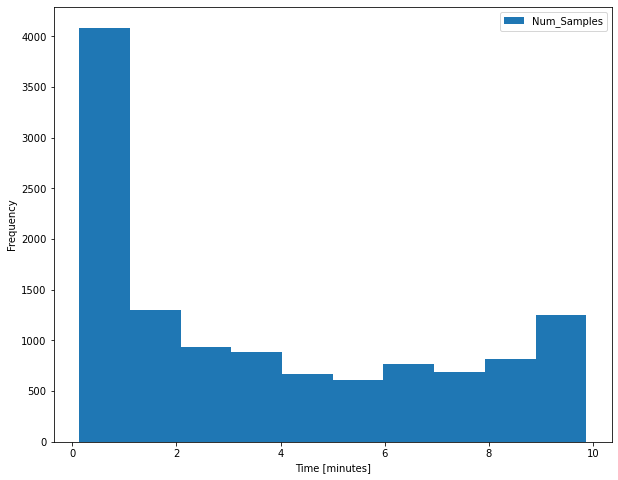

In [231]:
#Signals.head()
plt.rcParams["figure.figsize"]=10,8
Data_intervals_minutes = Data_Indices/Fs/60
Data_intervals_minutes.plot(kind='hist', bins=10)
plt.xlabel("Time [minutes]");

## 1) Data Loading & Visual Insights

### 1.2 Brief Statistics

In [31]:
Signals.describe()

,PPG,ABP,ECG
count,3.206100e+07,3.206100e+07,3.206100e+07
mean,1.687430e+00,9.141352e+01,1.328383e-01
std,6.868612e-01,2.832491e+01,5.900136e-01
min,0.000000e+00,5.001600e+01,-3.498000e+00
25%,1.154400e+00,6.935900e+01,-1.413000e-01
50%,1.504400e+00,8.328900e+01,2.651400e-01
75%,2.225800e+00,1.078500e+02,5.048900e-01
max,4.002000e+00,1.999100e+02,4.500000e+00


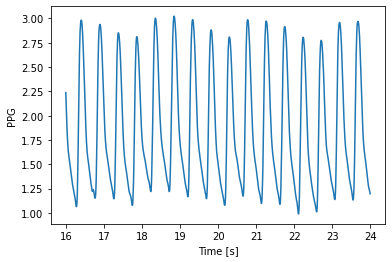

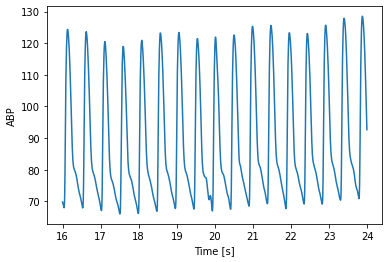

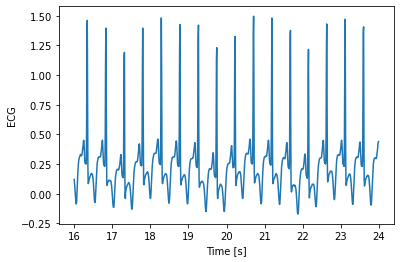

<Figure size 432x288 with 0 Axes>

In [60]:
# Just looking at the signals
import numpy as np
plot_signals = ['PPG','ABP','ECG']
N = 2000
St = 2000
samples = np.arange(St,St+N)
d = {}
for i in plot_signals: 
    d[i] = Signals[i][samples]

for i in plot_signals: 
    plt.plot((1/Fs)*samples, d[i])
    plt.xlabel("Time [s]");
    plt.ylabel(i);
    plt.figure()

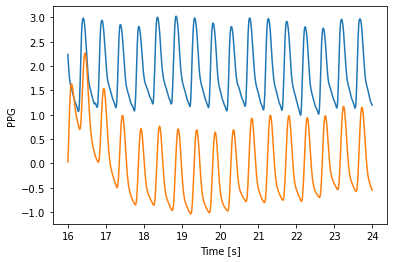

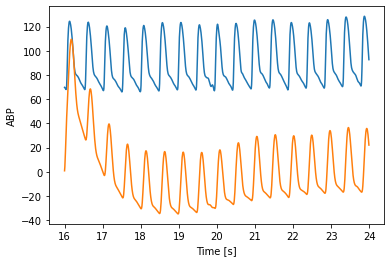

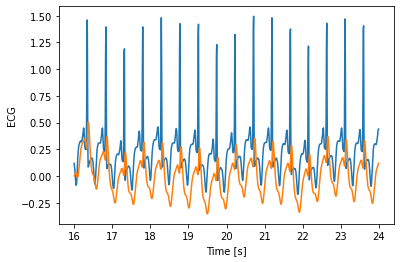

<Figure size 432x288 with 0 Axes>

In [93]:
# BPF, 3-point avg,remove trend (baseline)
# 1) BPF 
from scipy.signal import butter, lfilter
d_filtered = {} # init dict for filtered data

# filter design (reuse with unfiltered data)
fc1, fc2 = 0.5, 20 # low & high cutoff frequencies are 0.5, 20 for the PPG signal as in Kachuee2019 (0.5, 5 in 2020 paper)
b, a = butter(2, [fc1/Fs/2, fc2/Fs/2], btype= 'bandpass') # 3rd order ButterWorth BPF

for i in plot_signals: 
    d_filtered[i] = lfilter(b, a, d[i])

for i in plot_signals: 
    plt.plot((1/Fs)*samples, d[i])
    plt.plot((1/Fs)*samples, d_filtered[i])
    plt.xlabel("Time [s]");
    plt.ylabel(i);
    plt.figure()

1000


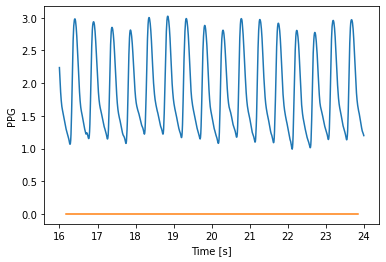

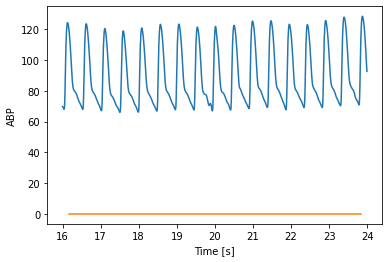

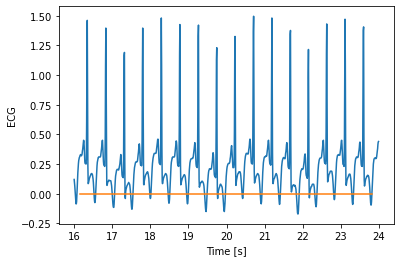

<Figure size 432x288 with 0 Axes>

In [74]:
# BPF, 3-point avg,remove trend (baseline)
from scipy import signal
diff_shift = 20
d_detrend = {}
for i in plot_signals: 
    #d_detrend[i] = signal.detrend(d[i])
    
    d_detrend[i] = d[i][:-1*diff_shift] - d[i][diff_shift:]
    
print(len(d_detrend['ECG']))

for i in plot_signals: 
    plt.plot((1/Fs)*samples, d[i])
    plt.plot((1/Fs)*samples, d_detrend[i])
    #plt.plot((1/Fs)*samples, d_processed[i])
    plt.xlabel("Time [s]");
    plt.ylabel(i);
    plt.figure()

## 3) Preparing Data for Regression [Predictive Models]

### 3.1 Splitting data between Train & Test

In [192]:
Total_length = len(All_Instants_Data.index)
strat_train_set = All_Instants_Data.loc[:8*Total_length//10,['PTT','HR','SBP']]
strat_test_set = All_Instants_Data.loc[8*Total_length//10:,['PTT','HR','SBP']]   
Data_label = "SBP"
# Copying Train & Test data & Keeping the labels aside for the evaluation later
train_copy = strat_train_set.copy() # deleting it from the data that we will transform
train_labels = train_copy[Data_label].copy() # keeping the label aside 
train_copy.drop([Data_label], axis=1, inplace=True)
test_copy = strat_test_set.copy() # deleting it from the data that we will transform
test_labels = test_copy[Data_label].copy() # keeping the label aside 
test_copy.drop([Data_label], axis=1, inplace=True)

### 3.2 Pipelines for Data Cleansing 

In [205]:
#%% Preprocessing Train & Test Data:
# Preparing Train Data:
from sklearn.impute import SimpleImputer ########################################################
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') ###########################################

#imputer = Imputer(strategy="median") # defining whcih value is gonna replace the missing data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
train_pipeline = Pipeline([
        ('imputer', imputer),
        ('std_scaler', StandardScaler()),
    ])
train_copy2_tr = train_pipeline.fit_transform(train_copy) # now it is a complete matrix, mean=0, var=1

# Preparing Test Data:
test_pipeline = Pipeline([
        ('imputer', imputer),
        ('std_scaler', StandardScaler()),
    ])
test_copy_tr = test_pipeline.fit_transform(test_copy)
#####################################################################################################

## 4) Learning & Testing & Evaluation using different models:

### 4.1 Linear Regression

In [206]:
#%% Learning & Testing & Evaluation using different models:
import numpy as np
#    1) Linear Regression:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_copy2_tr, train_labels)     # Model trained! 
LR_Predictions= lin_reg.predict(test_copy_tr)
from sklearn.metrics import mean_squared_error
LR_mse = mean_squared_error(test_labels, LR_Predictions)
LR_rmse = np.sqrt(LR_mse)
print("Linear Regression RMSE: ",LR_rmse)

Linear Regression RMSE:  15.928245970550295


### 4.2 Decision Tree

In [207]:
#    2) DecisionTreeRegressor: More powerful & models non-linearities 
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_copy2_tr, train_labels)
TR_Predictions = tree_reg.predict(test_copy_tr)
TR_mse = mean_squared_error(test_labels, TR_Predictions)
TR_rmse = np.sqrt(TR_mse)
print("DecisionTree Regression RMSE: ",TR_rmse)

DecisionTree Regression RMSE:  26.076371429600655


Text(0.5, 0, 'Data Points')

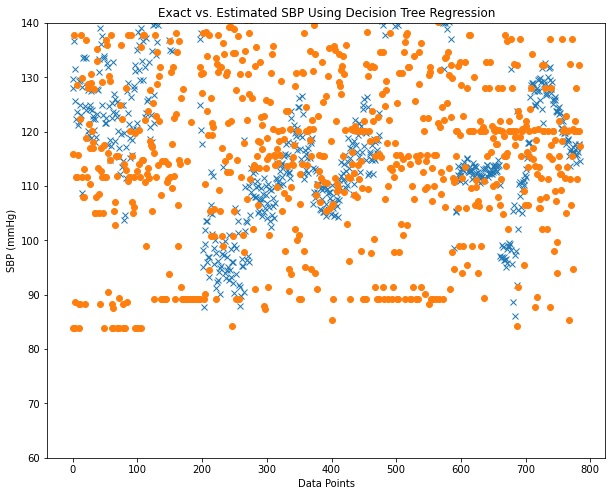

In [208]:
plt.plot(test_labels.values,'x')
plt.plot(TR_Predictions,'o')
plt.ylim(60,140)
plt.title("Exact vs. Estimated SBP Using Decision Tree Regression")
plt.ylabel("SBP (mmHg)")
plt.xlabel("Data Points")

Text(0, 0.5, 'Error')

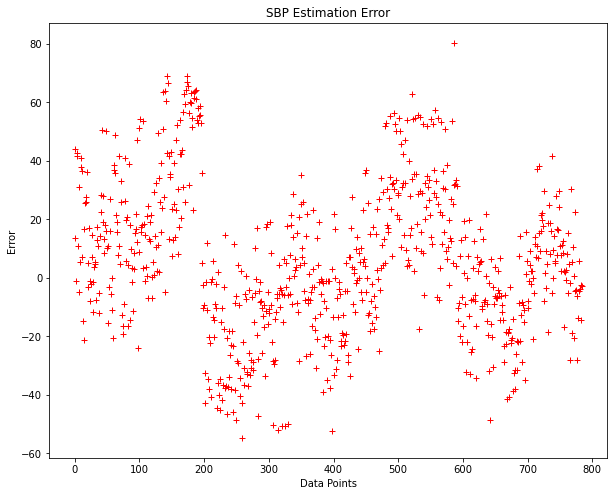

In [209]:
Est_Error_TR = test_labels.values - TR_Predictions
plt.plot(Est_Error_TR,'r+')
plt.title("SBP Estimation Error")
plt.xlabel("Data Points")
plt.ylabel("Error")

### 4.3 Random Forest

In [210]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(train_copy2_tr, train_labels)
FR_Predictions = forest_reg.predict(test_copy_tr)
FR_mse = mean_squared_error(test_labels, FR_Predictions)
FR_rmse = np.sqrt(FR_mse)
print("Random Forest Regression RMSE: ",FR_rmse)

Random Forest Regression RMSE:  23.144579792411346


### 4.4 SVM

In [211]:
#    4) SVM: Support Vector Machine (Linear and Non-Linear)
# Linear SVM
from sklearn.svm import LinearSVR
SVM_reg = LinearSVR(epsilon=.1)
SVM_reg.fit(train_copy2_tr, train_labels)
SVM_Predictions = SVM_reg.predict(test_copy_tr)
SVM_mse = mean_squared_error(test_labels, SVM_Predictions)
SVM_rmse = np.sqrt(SVM_mse)
print("SVM Regression RMSE: ",SVM_rmse)
# SVM with Poly Kernel
from sklearn.svm import SVR
SVM_poly_reg = SVR(kernel="poly", degree=1, C=60, epsilon=1)
SVM_poly_reg.fit(train_copy2_tr, train_labels)
SVM_poly_Predictions = SVM_poly_reg.predict(test_copy_tr)
SVM_poly_mse = mean_squared_error(test_labels, SVM_poly_Predictions)
SVM_poly_rmse = np.sqrt(SVM_poly_mse)
print("SVM with kernel Regression RMSE: ",SVM_poly_rmse)

abs_error = [abs(test_labels.values[l] - SVM_Predictions[l]) for l in range(len(SVM_Predictions))]
mean_error_vec = [sum(abs_error)/len(abs_error)]*len(abs_error)

SVM Regression RMSE:  15.84056216655993
SVM with kernel Regression RMSE:  15.814911149396341


## 3) DBP Estimation

### 3.1 Inserting DBP Values

## 4) Preparing Data for Regression [Predictive Models]

### 4.1 Splitting data between Train & Test

In [212]:
Total_length = len(All_Instants_Data.index)
cols_DBP=["PTT","HR","DBP"]
All_Instants_Data.dropna(inplace=True)
strat_train_set_DBP = All_Instants_Data.loc[:8*Total_length//10,cols_DBP]
strat_test_set_DBP = All_Instants_Data.loc[8*Total_length//10:,cols_DBP]   
Data_label_DBP = "DBP"
# Copying Train & Test data & Keeping the labels aside for the evaluation later
train_copy_DBP = strat_train_set_DBP.copy() # deleting it from the data that we will transform
train_labels_DBP = train_copy_DBP[Data_label_DBP].copy() # keeping the label aside 
train_copy_DBP.drop([Data_label_DBP], axis=1, inplace=True)
test_copy_DBP = strat_test_set_DBP.copy() # deleting it from the data that we will transform
test_labels_DBP = test_copy_DBP[Data_label_DBP].copy() # keeping the label aside 
test_copy_DBP.drop([Data_label_DBP], axis=1, inplace=True)

### 3.2 Pipelines for Data Cleansing 

In [213]:
#%% Preprocessing Train & Test Data:
# Preparing Train Data:
from sklearn.preprocessing import Imputer
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
imputer = Imputer(strategy="median") # defining whcih value is gonna replace the missing data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
train_pipeline_DBP = Pipeline([
        ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('train',train_copy_DBP)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
train_copy2_tr_DBP = train_pipeline_DBP.fit_transform(train_copy_DBP) # now it is a complete matrix, mean=0, var=1

# Preparing Test Data:
test_pipeline_DBP = Pipeline([
        ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('test',test_copy_DBP)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
test_copy_tr_DBP = test_pipeline_DBP.fit_transform(test_copy_DBP)
#####################################################################################################

ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing' (C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\sklearn\preprocessing\__init__.py)

## 4) Learning & Testing & Evaluation using different models:

### 4.1 Linear Regression

In [111]:
#%% Learning & Testing & Evaluation using different models:
import numpy as np
#    1) Linear Regression:
from sklearn.linear_model import LinearRegression
lin_reg_DBP = LinearRegression()
lin_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)     # Model trained! 
LR_Predictions_DBP= lin_reg_DBP.predict(test_copy_tr_DBP)
from sklearn.metrics import mean_squared_error
LR_mse_DBP = mean_squared_error(test_labels_DBP, LR_Predictions_DBP)
LR_rmse_DBP = np.sqrt(LR_mse_DBP)
print("Linear Regression RMSE: ",LR_rmse_DBP)

Linear Regression RMSE:  3.264308533476606


### 4.2 Decision Tree

In [112]:
#    2) DecisionTreeRegressor: More powerful & models non-linearities 
from sklearn.tree import DecisionTreeRegressor
tree_reg_DBP = DecisionTreeRegressor()
tree_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
TR_Predictions_DBP = tree_reg_DBP.predict(test_copy_tr_DBP)
TR_mse_DBP = mean_squared_error(test_labels_DBP, TR_Predictions_DBP)
TR_rmse_DBP = np.sqrt(TR_mse_DBP)
print("DecisionTree Regression RMSE: ",TR_rmse_DBP)

DecisionTree Regression RMSE:  4.00275453026356


### 4.3 Random Forest

In [118]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor
forest_reg_DBP = RandomForestRegressor()
forest_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
FR_Predictions_DBP = forest_reg_DBP.predict(test_copy_tr_DBP)
FR_mse_DBP = mean_squared_error(test_labels_DBP, FR_Predictions_DBP)
FR_rmse_DBP = np.sqrt(FR_mse_DBP)
print("Random Forest Regression RMSE: ",FR_rmse_DBP)

Random Forest Regression RMSE:  3.1514842110643837


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


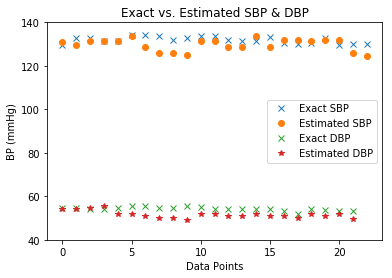

In [120]:
plt.plot(test_labels.values,'x', label='Exact SBP') # SBP values first
plt.plot(TR_Predictions,'o', label='Estimated SBP') # SBP estimates
plt.plot(test_labels_DBP.values,'x', label='Exact DBP')
plt.plot(FR_Predictions_DBP,'*', label='Estimated DBP')
plt.ylim(40,140)
plt.title("Exact vs. Estimated SBP & DBP")
plt.ylabel("BP (mmHg)")
plt.xlabel("Data Points")
plt.legend(loc="center right")

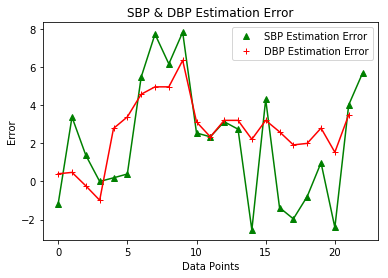

In [122]:
Est_Error_FR_DBP = test_labels_DBP.values - FR_Predictions_DBP
plt.plot(Est_Error_TR,'g')
plt.plot(Est_Error_TR,'g^', label='SBP Estimation Error')
plt.plot(Est_Error_FR_DBP,'r')
plt.plot(Est_Error_FR_DBP,'r+', label='DBP Estimation Error')
plt.title("SBP & DBP Estimation Error")
plt.xlabel("Data Points")
plt.ylabel("Error")
plt.legend(loc="upper right")

### 4.4 SVM

In [119]:
#    4) SVM: Support Vector Machine (Linear and Non-Linear)
# Linear SVM
from sklearn.svm import LinearSVR
SVM_reg_DBP = LinearSVR(epsilon=1.5)
SVM_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
SVM_Predictions_DBP = SVM_reg_DBP.predict(test_copy_tr_DBP)
SVM_mse_DBP = mean_squared_error(test_labels_DBP, SVM_Predictions_DBP)
SVM_rmse_DBP = np.sqrt(SVM_mse_DBP)
print("SVM Regression RMSE: ",SVM_rmse_DBP)
# SVM with Poly Kernel
from sklearn.svm import SVR
SVM_poly_reg_DBP = SVR(kernel="poly", degree=2, C=100, epsilon=.1)
SVM_poly_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
SVM_poly_Predictions_DBP = SVM_poly_reg_DBP.predict(test_copy_tr_DBP)
SVM_poly_mse_DBP = mean_squared_error(test_labels_DBP, SVM_poly_Predictions_DBP)
SVM_poly_rmse_DBP = np.sqrt(SVM_poly_mse_DBP)
print("SVM with kernel Regression RMSE: ",SVM_poly_rmse_DBP)

abs_error_DBP = [abs(test_labels_DBP.values[l] - SVM_Predictions_DBP[l]) for l in range(len(SVM_Predictions_DBP))]
mean_error_vec_DBP = [sum(abs_error_DBP)/len(abs_error_DBP)]*len(abs_error_DBP)

SVM Regression RMSE:  4.977740515797924
SVM with kernel Regression RMSE:  3.7719486796332466
